### Imports

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

### standard values

In [2]:
gate_ctt = np.array([165, 315, 465, 615, 765, 915, 1065, 1215, 1365, 1515], dtype = int)

In [3]:
g_en5 = -7.711545013271975

In [4]:
nseeds = 10

In [5]:
dep = np.arange(1, 11, 1, dtype = int)

In [6]:
base_expo = [[1,6], [5,6], [1,5], [5,5], [1,4], [5,4], [1,3]]

In [7]:
eps = [b[0]*(10**(-b[1])) for b in base_expo]

In [8]:
perr = []
exp_off = []
for yt in range(len(eps)):
    p_er = np.array(1 - (1-eps[yt])**gate_ctt)
    perr.append(perr)
    exp_off.append(1 - p_er)

### noiseless data

In [9]:
with open('Results/noiseless_COBY_rand_runs.pkl', 'rb') as file:
    yruns = pickle.load(file)

In [10]:
with open('Results/noiseless_COBY_rand_list.pkl', 'rb') as file:
    ylist = pickle.load(file)

In [11]:
res_data_idm = []
res_data_ids = []
val_list_idm = []
val_list_ids = []

In [12]:
for gt in dep:
    yran = np.array(yruns['%s'%gt])
    ylis = np.array(ylist['%s'%gt])
    # Compute mean and standard deviation across runs
    mean_y = np.mean(yran, axis=0)
    std_y = np.std(yran, axis=0)
    val = np.mean(ylis, axis=0)
    val_std = np.std(ylis, axis=0)
    res_data_idm.append(mean_y)
    res_data_ids.append(std_y)
    val_list_idm.append(val)
    val_list_ids.append(val_std)

### noisy data

In [13]:
noisy_data_mean = {}
noisy_data_std = {}
noisy_data_val_m = {}
noisy_data_val_s = {}
for gt in range(len(base_expo)):
    #with open('global_noisy_seeds_gates/noisy-%s_%s.pkl'%(base_expo[gt][0], base_expo[gt][1]), 'rb') as file:
    with open('Results/global_noisy_gates_seeds_assumptions_COBY_scipy/noisy-%s_%s.pkl'%(base_expo[gt][0], base_expo[gt][1]), 'rb') as file:
        res = pickle.load(file)
    res_data_mean = []
    res_data_std = []
    val_list = []
    val_std = []
    for pt in dep:
        yran = []
        ylis = []
        for ht in np.arange(0, nseeds, 1, dtype = int):
            re = eval(res['%s'%ht][pt-1].meta_data['optimization_trace'])
            vv = res['%s'%ht][pt-1].value
            app = [vv for yt in range(25000-len(re))]
            yran.append(re + app)
            ylis.append(vv)
        yseed_opt = np.array(yran)
        yseed_val = np.array(ylis)
        mean_y = np.mean(yseed_opt, axis=0)
        std_y = np.std(yseed_opt, axis=0)
        val = np.mean(yseed_val, axis=0)
        val_sig = np.std(yseed_val, axis=0)
        res_data_mean.append(mean_y)
        res_data_std.append(std_y)
        val_list.append(val)
        val_std.append(val_sig)
    noisy_data_mean['%s'%gt] = res_data_mean
    noisy_data_std['%s'%gt] = res_data_std
    noisy_data_val_m['%s'%gt] = val_list
    noisy_data_val_s['%s'%gt] = val_std

### selected noiseless data plot

In [14]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(-b * x)

In [15]:
plt.rcParams.update({'font.size': 16})
#plt.rcParams['font.family'] = 'serif'  # or 'sans-serif', 'monospace', etc.
#plt.rcParams['font.serif'] = ['Times New Roman']

#### exponential decay in noiseless for plot only

/tmp/ipykernel_7179/2599236198.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)


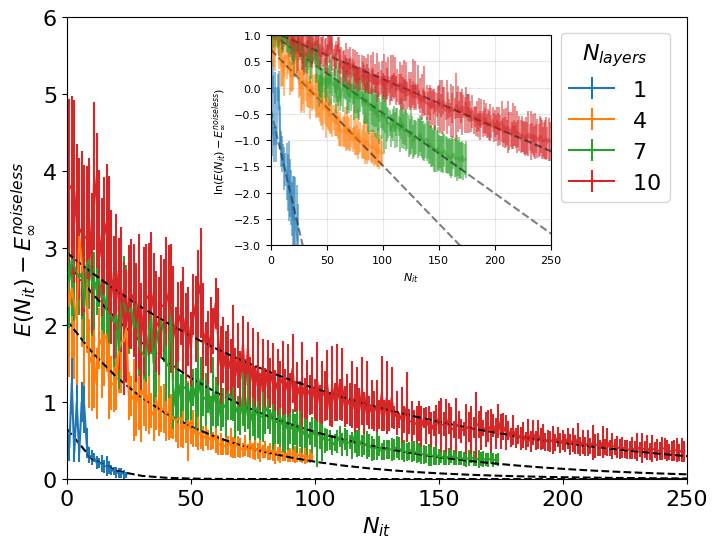

In [16]:
# Create main figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Create inset axes for log-linear plot
inset_ax = fig.add_axes([0.38, 0.5, 0.35, 0.35])  # [left, bottom, width, height]

gam = []
gam_err = []
xx = np.arange(0, 25000, 1, dtype=int)
fit_ran = 25

for gt in range(0, len(res_data_idm), 3):
    fit_range = (gt+1)*fit_ran
    yy = np.array(res_data_idm[gt])-val_list_idm[gt]
    xp = xx[0:fit_range]
    yp = yy[0:fit_range]
    std_devs = res_data_ids[gt][0:fit_range]

    # Fit model with weights
    params, cv = curve_fit(exp_model, xp, yp, sigma=std_devs, absolute_sigma=True)
    a, b = params
    a_err, b_err = np.sqrt(np.diag(cv))
    gam_err.append(b_err)
    gam.append(b)

    # Plot in main axes
    ax.errorbar(xp, yp, yerr=std_devs, fmt='-', label=r'$%s$' %(gt+1))
    
    # Plot fitted exponential model in main axes
    x_fit = np.linspace(0, 1000, 100)
    y_fit = exp_model(x_fit, a, b)
    ax.plot(x_fit, y_fit, '--k')
    
    # Plot in inset (log-linear)
    inset_ax.errorbar(xp, np.log(yp), yerr=std_devs/yp, fmt='-', alpha=0.5)
    inset_ax.plot(x_fit, np.log(y_fit), '--k', alpha=0.5)

# Main axes settings
#ax.set_yscale('log')
ax.set_xlabel(r'$N_{it}$')
ax.set_ylabel(r'$ E(N_{it}) - E_{\infty}^{noiseless}$')
ax.set_xlim(0, 250)
ax.set_ylim(0, 6)
ax.legend(bbox_to_anchor=(0.99, 0.99), title=r'$N_{layers}$')

# Inset axes settings
inset_ax.set_xlim(0, 250)
inset_ax.set_ylim(-3, 1)
inset_ax.set_xlabel(r'$N_{it}$', fontsize=8)
inset_ax.set_ylabel(r'$\ln(E(N_{it}) - E_{\infty}^{noiseless})$', fontsize=8)
inset_ax.tick_params(axis='both', which='major', labelsize=8)
inset_ax.grid(True, alpha=0.3)
#plt.savefig('Figs/noiseless_E_t_inset.pdf', bbox_inches='tight')
plt.show()

#### for all depths for complete analysis

/tmp/ipykernel_7179/2599236198.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
/tmp/ipykernel_7179/2599236198.py:3: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)


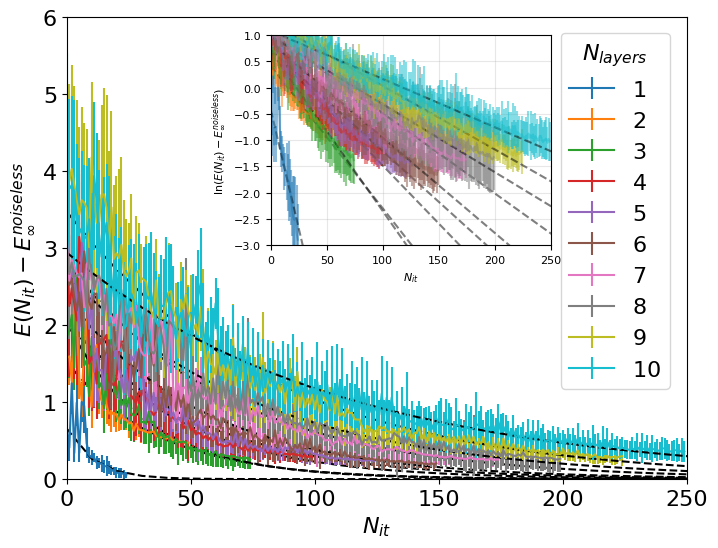

In [17]:
# Create main figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Create inset axes for log-linear plot
inset_ax = fig.add_axes([0.38, 0.5, 0.35, 0.35])  # [left, bottom, width, height]

gam = []
gam_err = []
xx = np.arange(0, 25000, 1, dtype=int)
fit_ran = 25

for gt in range(0, len(res_data_idm), 1):
    fit_range = (gt+1)*fit_ran
    yy = np.array(res_data_idm[gt])-val_list_idm[gt]
    xp = xx[0:fit_range]
    yp = yy[0:fit_range]
    std_devs = res_data_ids[gt][0:fit_range]

    # Fit model with weights
    params, cv = curve_fit(exp_model, xp, yp, sigma=std_devs, absolute_sigma=True)
    a, b = params
    a_err, b_err = np.sqrt(np.diag(cv))
    gam_err.append(b_err)
    gam.append(b)

    # Plot in main axes
    ax.errorbar(xp, yp, yerr=std_devs, fmt='-', label=r'$%s$' %(gt+1))
    
    # Plot fitted exponential model in main axes
    x_fit = np.linspace(0, 1000, 100)
    y_fit = exp_model(x_fit, a, b)
    ax.plot(x_fit, y_fit, '--k')
    
    # Plot in inset (log-linear)
    inset_ax.errorbar(xp, np.log(yp), yerr=std_devs/yp, fmt='-', alpha=0.5)
    inset_ax.plot(x_fit, np.log(y_fit), '--k', alpha=0.5)

# Main axes settings
#ax.set_yscale('log')
ax.set_xlabel(r'$N_{it}$')
ax.set_ylabel(r'$ E(N_{it}) - E_{\infty}^{noiseless}$')
ax.set_xlim(0, 250)
ax.set_ylim(0, 6)
ax.legend(bbox_to_anchor=(0.99, 0.99), title=r'$N_{layers}$')

# Inset axes settings
inset_ax.set_xlim(0, 250)
inset_ax.set_ylim(-3, 1)
inset_ax.set_xlabel(r'$N_{it}$', fontsize=8)
inset_ax.set_ylabel(r'$\ln(E(N_{it}) - E_{\infty}^{noiseless})$', fontsize=8)
inset_ax.tick_params(axis='both', which='major', labelsize=8)
inset_ax.grid(True, alpha=0.3)
#plt.savefig('figs/noiseless_E_t_inset.pdf', bbox_inches='tight')
plt.show()

### fitting convergence rate

In [18]:
n_lay = 10

In [19]:
# Define power law
def noiseless_power_model(x, a, b):
    return a * ((x-100)**-b)

/tmp/ipykernel_7179/199349251.py:3: RuntimeWarning: divide by zero encountered in power
  return a * ((x-100)**-b)


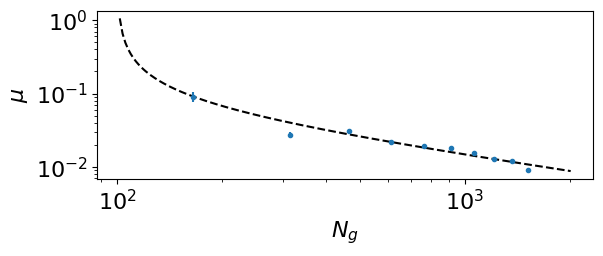

In [20]:
#fitting power law on noiseless gamma
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
plt.errorbar(gate_ctt[0:n_lay], gam[0:n_lay], yerr=gam_err[0:n_lay], fmt='.')
#pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)

#Fit model with weights
pm, cv = curve_fit(noiseless_power_model, gate_ctt[0:n_lay], gam[0:n_lay], sigma=gam_err[0:n_lay], absolute_sigma=True)
a, b = pm
a_err, b_err = np.sqrt(np.diag(cv))
#Plot fitted model
x_fit = np.linspace(100, gate_ctt[n_lay-1]+500, 1000)
y_fit = noiseless_power_model(x_fit, a, b)
#plt.plot(x_fit, y_fit)

y_fitt = noiseless_power_model(gate_ctt[0:n_lay], a, b)

residuals = np.array(gam[0:n_lay]) - y_fitt
chi_sq = np.sum(np.divide(residuals, np.array(gam_err[0:n_lay])))
ss_res = np.sum(residuals**2)
ss_tot = np.sum(( np.array(gam[0:n_lay])-np.mean( np.array(gam[0:n_lay])))**2)
r_sq = 1 - (ss_res / ss_tot)

# Create sequence of 100 numbers from 0 to 100 
#xn = np.linspace(1, gate_ct[n_lay-1], num=50)

# Plot regression line
ax.plot(x_fit, y_fit, '--k', lw=1.5);
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
ax.set_ylabel(r'$ \mu$')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([100,2000])
#ax.set_ylim([0.005,0.5])
#plt.savefig('noiseless_gamma_fit.pdf', bbox_inches = 'tight')
plt.show()

In [21]:
print(a, a_err, b, b_err)

1.6652961475559356 0.2782930445114287 0.6945170386256264 0.02433834055155108


In [22]:
print(r_sq, chi_sq)

0.9636009055645968 0.36854870045077526


### selected noisy data plot

In [23]:
sel = 2

In [24]:
base_expo[sel]

[1, 5]

In [25]:
res_data_mean = noisy_data_mean['%s'%sel]
res_data_std = noisy_data_std['%s'%sel]
val_list = noisy_data_val_m['%s'%sel]

In [26]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(-b * x)

/tmp/ipykernel_7179/2599236198.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
/tmp/ipykernel_7179/2599236198.py:3: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)
/home/harshit-verma/Desktop/eviden/eviden/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:538: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


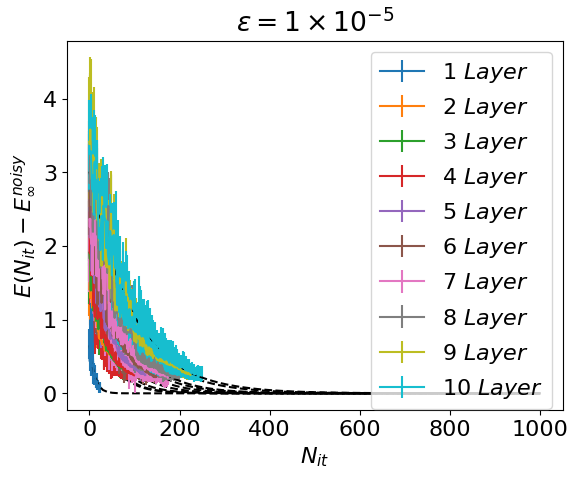

In [27]:
#fitting using the mean data with error propagation
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
alp = []
alp_err = []
E00 = []
E00_err = []
xx = np.arange(0, 25000, 1, dtype = int)
fit_ran = 25
for gt in range(0, len(res_data_mean), 1): 
#for gt in [3]:
    fit_range = (gt+1)*fit_ran
    yy = np.array(res_data_mean[gt])-val_list[gt]
    xp = xx[0:fit_range]
    yp = yy[0:fit_range]
    std_devs = res_data_std[gt][0:fit_range]

    # Fit model with weights
    params, cv = curve_fit(exp_model, xp, yp, sigma=std_devs, absolute_sigma=True)
    a, b = params
    a_err, b_err = np.sqrt(np.diag(cv))
    alp_err.append(b_err)
    alp.append(b)
    E00.append(a)
    E00_err.append(a_err)
    #y_fit = exp_model(xp, a, b)

    plt.errorbar(xp, yp, yerr=std_devs, fmt='-', label = r'$%s~Layer$' %(gt+1))

    # Plot fitted exponential model
    x_fit = np.linspace(0, 1000, 100)
    y_fit = exp_model(x_fit, a, b)
    #plt.plot(x_fit, y_fit, '--k', label= r'$F~%s~Layer$' %(gt+1))
    plt.plot(x_fit, y_fit, '--k')

plt.title(r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[sel][0], base_expo[sel][1]))
#ax.set_yscale('log')
ax.set_xlabel(r'$N_{it}$')
ax.set_ylabel(r'$ E(N_{it}) - E_{\infty}^{noisy}$')
#plt.axis([0, 250, 0, 4])
#ax.legend(ncol = 2, bbox_to_anchor = (1, 0.1))
ax.legend()
#plt.savefig('noisy_alpha.pdf', bbox_inches = 'tight')
plt.show()

In [28]:
E00

[0.6506625678681646,
 1.4491038784931785,
 1.7854402893492778,
 1.7827160882663913,
 2.035210451684324,
 2.2563943790526695,
 2.289176626561238,
 2.854940709019242,
 2.8200890787383495,
 3.0083478380046924]

In [29]:
E00_err

[0.09632044459240546,
 0.1139766458082713,
 0.12426349859268943,
 0.13816492293287275,
 0.10706620842030715,
 0.12464913280480094,
 0.14522079158525655,
 0.10786451149445078,
 0.10303661128896936,
 0.09357102469911378]

In [30]:
alp

[0.08859161362721196,
 0.024854547951912245,
 0.025299413315157684,
 0.021893940519599614,
 0.01839246968653899,
 0.016208981567594878,
 0.014329186546132768,
 0.014141717455241454,
 0.011243731168321206,
 0.010570399434657022]

In [31]:
alp_err

[0.013184753612289778,
 0.002730058776496661,
 0.0018429823346110311,
 0.0013363128083201722,
 0.0007937082110737534,
 0.000667469045191128,
 0.0006804454633392052,
 0.00031439629491139933,
 0.00029096547912044624,
 0.0002692690244213152]

### fitting noisy $\alpha$ for all $\epsilon$

In [32]:
n_lay = 10

In [33]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(-b * x)

In [34]:
alp_list = []
alp_err_list = []
xx = np.arange(0, 25000, 1, dtype = int)
fit_ran = 25
for gt in range(len(base_expo)):
    res_data_mean = noisy_data_mean['%s'%gt]
    res_data_std = noisy_data_std['%s'%gt]
    val_list = noisy_data_val_m['%s'%gt]
    #fitting using the mean data with error propagation
    alp = []
    alp_err = []
    for gt in range(0, len(res_data_mean), 1):
        fit_range = (gt+1)*fit_ran
        yy = np.array(res_data_mean[gt])-val_list[gt]
        xp = xx[0:fit_range]
        yp = yy[0:fit_range]
        std_devs = res_data_std[gt][0:fit_range]
        # Fit model with weights
        params, cv = curve_fit(exp_model, xp, yp, sigma=std_devs, absolute_sigma=True)
        a, b = params
        a_err, b_err = np.sqrt(np.diag(cv))
        alp_err.append(b_err)
        alp.append(b)
    alp_list.append(alp)
    alp_err_list.append(alp_err)

/tmp/ipykernel_7179/2599236198.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
/tmp/ipykernel_7179/2599236198.py:3: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)


In [35]:
# Define fit model
def noisy_power_model(x, a, b):
    #return a * np.exp(-b * x)
    return a * ((x-100)**-b)

In [36]:
import itertools
marker = itertools.cycle(('o', 'v', 's', 'd', '*', '^', 'x', 'p')) 

### Plotting $\nu$

/tmp/ipykernel_7179/1853952620.py:4: RuntimeWarning: divide by zero encountered in power
  return a * ((x-100)**-b)


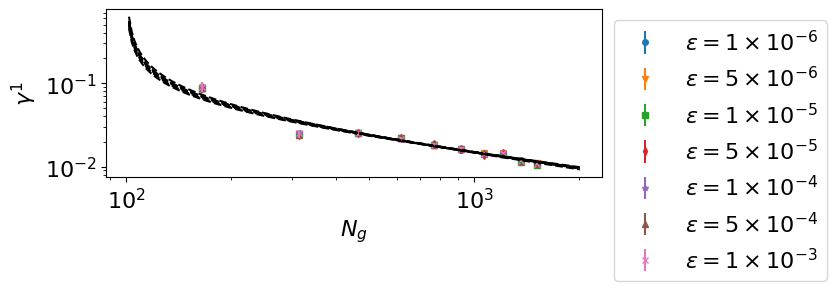

In [37]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
resi = []
rsq = []
csq = []
alp_err_fit = []
alp_fit = []
bet_err_fit = []
bet_fit = []
for gt in range(len(alp_list)):
    plt.errorbar(gate_ctt[0:n_lay], alp_list[gt][0:n_lay], yerr=alp_err_list[gt][0:n_lay], fmt = next(marker), markersize=4, barsabove = True, label = r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[gt][0], base_expo[gt][1]))
    #pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)
        
    #Fit model with weights
    pm, cv = curve_fit(noisy_power_model, gate_ctt[0:n_lay], alp_list[gt][0:n_lay], sigma=alp_err_list[gt][0:n_lay], absolute_sigma=True)
    a, b = pm
    a_err, b_err = np.sqrt(np.diag(cv))
    #Plot fitted exponential model
    x_fit = np.linspace(100, gate_ctt[n_lay-1]+500, 1000)
    y_fit = noisy_power_model(x_fit, a, b)
    #plt.plot(x_fit, y_fit)
    
    #for evaluating residuals
    y_fitt = noisy_power_model(gate_ctt[0:n_lay], a, b)
    
    residuals = np.array(alp_list[gt][0:n_lay]) - y_fitt
    chi_sq = np.sum((residuals / np.array(alp_err_list[gt][0:n_lay]))**2)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum(( np.array(alp_list[gt][0:n_lay])-np.mean(np.array(alp_list[gt][0:n_lay])))**2)
    r_sq = 1 - (ss_res / ss_tot)

    resi.append(residuals)
    rsq.append(r_sq)
    csq.append(chi_sq)

    alp_err_fit.append(a_err)
    bet_err_fit.append(b_err)
    alp_fit.append(a)
    bet_fit.append(b)
    
    # Create sequence of 100 numbers from 0 to 100 
    #xn = np.linspace(1, gate_ct[n_lay-1], num=50)
    
    # Plot regression line
    ax.plot(x_fit, y_fit, '--k', lw=1.5);
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
    
#plt.savefig('noiseless_gamma_fit.pdf', bbox_inches = 'tight')
plt.legend(bbox_to_anchor = (1, 1))
ax.set_ylabel(r'$ \gamma^1$')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([50,1000])
#ax.set_ylim([0.005,0.5])
#plt.savefig('noisy_alpha_fit.pdf', bbox_inches = 'tight')
plt.show()

In [38]:
alp_fit

[0.7895646191594133,
 0.7113831791326065,
 0.9306282050194364,
 0.7662365318250074,
 0.7914052400996027,
 0.6525611910176676,
 0.8216792007185386]

In [39]:
alp_err_fit

[0.14982145752367426,
 0.13881795970760374,
 0.17642664857521115,
 0.14583556736958664,
 0.15084945975523617,
 0.12662932234046423,
 0.15762526147901934]

In [40]:
bet_fit

[0.5826557922731684,
 0.5689099911096763,
 0.6099497107257214,
 0.5800437891483741,
 0.5836713340880397,
 0.5549556583137737,
 0.5899297267392367]

In [41]:
bet_err_fit

[0.027437780317273827,
 0.028202187583780708,
 0.027305072181505876,
 0.027436733383180225,
 0.027506128135088386,
 0.02800668794501808,
 0.027668935333493516]

In [42]:
rsq

[0.9021775887119466,
 0.8741124608084343,
 0.9258421271670118,
 0.8896661336376159,
 0.8868455953958853,
 0.8576720224397663,
 0.8958514739209674]

In [43]:
csq

[36.18038885745331,
 48.51047124549948,
 44.4386212644773,
 45.22575044601003,
 37.01866422556171,
 34.26810501423854,
 41.501957326255464]

In [44]:
np.mean(alp_fit)

0.7804940238531817

In [45]:
np.mean(alp_err_fit)

0.1494293823929708

In [46]:
np.mean(bet_fit)

0.581445143199713

In [47]:
np.mean(bet_err_fit)

0.02765193212562009

In [48]:
strt = 0

### Plotting $\nu$ and $\mu$

/tmp/ipykernel_7179/199349251.py:3: RuntimeWarning: invalid value encountered in power
  return a * ((x-100)**-b)
/tmp/ipykernel_7179/1853952620.py:4: RuntimeWarning: invalid value encountered in power
  return a * ((x-100)**-b)


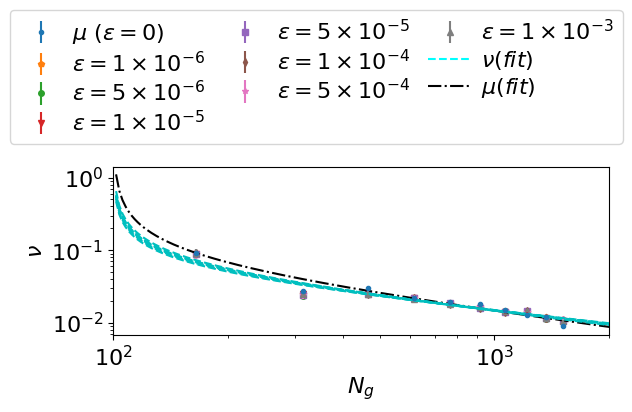

In [49]:
import matplotlib.lines as mlines

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
resi = []
rsq = []
csq = []
alp_err_fit = []
alp_fit = []
bet_err_fit = []
bet_fit = []

#firs noiseless gamma
plt.errorbar(gate_ctt[strt:n_lay], gam[strt:n_lay], yerr=gam_err[strt:n_lay], fmt='.',  label = r'$\mu~(\epsilon = 0)$')
#pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)

#Fit model with weights
pm, cv = curve_fit(noiseless_power_model, gate_ctt[strt:n_lay], gam[strt:n_lay], sigma=gam_err[strt:n_lay], absolute_sigma=True)
aa, bb = pm
aa_err, bb_err = np.sqrt(np.diag(cv))
#Plot fitted exponential model
x_fit = np.linspace(1, gate_ctt[n_lay-1]+500, 1000)
y_fit = noiseless_power_model(x_fit, aa, bb)
#plt.plot(x_fit, y_fit)

#for residual from exact points at fit points
y_fitt = noiseless_power_model(gate_ctt[strt:n_lay], aa, bb)

# Plot regression line
ax.plot(x_fit, y_fit, '-.k', lw=1.5);

resi_0 = np.array(gam[strt:n_lay]) - y_fitt
chi_sq_0 = np.sum((resi_0 / np.array(gam_err[strt:n_lay]))**2)
ss_res_0 = np.sum(resi_0**2)
ss_tot_0 = np.sum(( np.array(gam[strt:n_lay])-np.mean( np.array(gam[strt:n_lay])))**2)
r_sq_0 = 1 - (ss_res_0 / ss_tot_0)

# Create sequence of 100 numbers from 0 to 100 
#xn = np.linspace(1, gate_ct[n_lay-1], num=50)

#now noisy alpha

for gt in range(len(alp_list)):
    plt.errorbar(gate_ctt[strt:n_lay], alp_list[gt][strt:n_lay], yerr=alp_err_list[gt][strt:n_lay], fmt = next(marker), markersize=4, barsabove = True, label = r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[gt][0], base_expo[gt][1]))
    #pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)
        
    #Fit model with weights
    pm, cv = curve_fit(noisy_power_model, gate_ctt[strt:n_lay], alp_list[gt][strt:n_lay], sigma=alp_err_list[gt][strt:n_lay], absolute_sigma=True)
    a, b = pm
    a_err, b_err = np.sqrt(np.diag(cv))
    #Plot fitted exponential model
    x_fit = np.linspace(1, gate_ctt[n_lay-1]+500, 1000)
    y_fit = noisy_power_model(x_fit, a, b)
    #plt.plot(x_fit, y_fit)
    
    y_fitt = noisy_power_model(gate_ctt[strt:n_lay], a, b)
    
    residuals = np.array(alp_list[gt][strt:n_lay]) - y_fitt
    chi_sq = np.sum((residuals / np.array(alp_err_list[gt][strt:n_lay]))**2)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((np.array(alp_list[gt][strt:n_lay])-np.mean(np.array(alp_list[gt][strt:n_lay])))**2)
    r_sq = 1 - (ss_res / ss_tot)

    resi.append(residuals)
    rsq.append(r_sq)
    csq.append(chi_sq)

    alp_err_fit.append(a_err)
    bet_err_fit.append(b_err)
    alp_fit.append(a)
    bet_fit.append(b)
    
    # Create sequence of 100 numbers from 0 to 100 
    #xn = np.linspace(1, gate_ct[n_lay-1], num=50)
    
    # Plot regression line
    ax.plot(x_fit, y_fit, '--c', lw=1.5)

# Add an extra line in the legend
l4 = mlines.Line2D([], [], color="cyan", linestyle="--", label = r"$\nu(fit)$")
l5 = mlines.Line2D([], [], color="k", linestyle="-.", label = r"$\mu(fit)$")

# Get existing handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Add the extra line to the handles
handles.append(l4)
handles.append(l5)

# Create the legend with all lines
plt.legend(handles=handles, ncol = 3,     
           labelspacing=0.2,
            columnspacing=0.8,    # vertical space between entries (default ~0.5)
            bbox_to_anchor = (1.05, 2),
            handletextpad=0.4)   # space between handle and text

ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
    
#plt.savefig('noiseless_gamma_fit.pdf', bbox_inches = 'tight')
#plt.legend(bbox_to_anchor = (0.1, 1.1), ncol =3)
ax.set_ylabel(r'$ \nu$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([100, 2000])
#ax.set_ylim([0.005, 0.5])
#plt.savefig('Figs/noisy_alpha_fit_COBY.pdf', bbox_inches = 'tight')
plt.show()

#### Modified power law shown on log-log plot

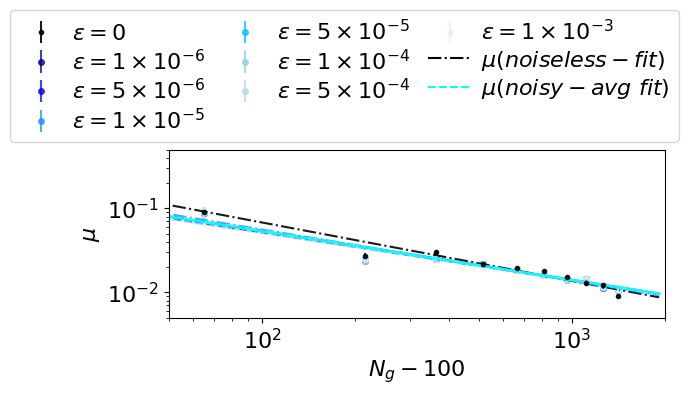

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
resi = []
rsq = []
csq = []
alp_err_fit = []
alp_fit = []
bet_err_fit = []
bet_fit = []

# ensure start index and n_lay are set
# strt = 0
# n_lay = 10

# Define shades of blue for noisy data (darker shades for better visibility)
blue_shades = ['#00008B', '#0000CD', '#0047AB', '#1E90FF', '#4169E1', '#5B9BD5', '#87CEEB']

# Define line styles for better distinction
line_styles = ['-', '--', '-.', ':', (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1)), (0, (5, 5))]

# Plot noiseless gamma vs (Ng-100)
x_data = gate_ctt[strt:n_lay]
x_shift = x_data - 100
plt.errorbar(x_shift, gam[strt:n_lay], yerr=gam_err[strt:n_lay], fmt='.', color='black', alpha=0.9, label=r'$\epsilon = 0$')

# Fit noiseless using original x (model uses (x-100))
pm, cv = curve_fit(noiseless_power_model, gate_ctt[strt:n_lay], gam[strt:n_lay], sigma=gam_err[strt:n_lay], absolute_sigma=True)
aa, bb = pm
aa_err, bb_err = np.sqrt(np.diag(cv))

# prepare x for plotting fit (avoid x==100)
x_fit = np.linspace(101, gate_ctt[n_lay-1] + 500, 1000)
y_fit = aa * ((x_fit - 100) ** -bb)
ax.plot(x_fit - 100, y_fit, '-.k', lw=1.5, alpha=0.9)

# noiseless fit stats
y_fitt = aa * ((gate_ctt[strt:n_lay] - 100) ** -bb)
resi_0 = np.array(gam[strt:n_lay]) - y_fitt
chi_sq_0 = np.sum((resi_0 / np.array(gam_err[strt:n_lay])) ** 2)
ss_res_0 = np.sum(resi_0 ** 2)
ss_tot_0 = np.sum((np.array(gam[strt:n_lay]) - np.mean(np.array(gam[strt:n_lay]))) ** 2)
r_sq_0 = 1 - (ss_res_0 / ss_tot_0)

# Plot noisy data and fits on shifted x axis
for gt in range(len(alp_list)):
    # mask non-positive values to avoid issues on log scale
    x_all = gate_ctt[strt:n_lay]
    x_sh = x_all - 100
    y_all = np.array(alp_list[gt][strt:n_lay])
    y_err = np.array(alp_err_list[gt][strt:n_lay])
    pos_mask = y_all > 0

    plt.errorbar(x_sh[pos_mask], y_all[pos_mask], yerr=y_err[pos_mask],
                 fmt='o', markersize=4, color=blue_shades[gt % len(blue_shades)], 
                 alpha=0.75, barsabove=True,
                 label=r'$\epsilon = %s \times 10^{-%s}$' % (base_expo[gt][0], base_expo[gt][1]))

    pm, cv = curve_fit(noisy_power_model, gate_ctt[strt:n_lay][pos_mask], y_all[pos_mask],
                       sigma=y_err[pos_mask], absolute_sigma=True)
    a, b = pm
    a_err, b_err = np.sqrt(np.diag(cv))

    x_fit_n = np.linspace(101, gate_ctt[n_lay-1] + 500, 1000)
    y_fit_n = a * ((x_fit_n - 100) ** -b)
    ax.plot(x_fit_n - 100, y_fit_n, linestyle=line_styles[gt % len(line_styles)], 
            color=blue_shades[gt % len(blue_shades)], lw=1.5, alpha=0.8)

    y_fitt_n = a * ((gate_ctt[strt:n_lay] - 100) ** -b)
    residuals = y_all - y_fitt_n
    chi_sq = np.sum((residuals[pos_mask] / y_err[pos_mask]) ** 2)
    ss_res = np.sum(residuals[pos_mask] ** 2)
    ss_tot = np.sum((y_all[pos_mask] - np.mean(y_all[pos_mask])) ** 2)
    r_sq = 1 - (ss_res / ss_tot)

    resi.append(residuals)
    rsq.append(r_sq)
    csq.append(chi_sq)
    alp_err_fit.append(a_err)
    bet_err_fit.append(b_err)
    alp_fit.append(a)
    bet_fit.append(b)

# Plot average noisy fit line (without label for manual legend control)
a_avg = np.mean(alp_fit)
b_avg = np.mean(bet_fit)
x_fit_avg = np.linspace(101, gate_ctt[n_lay-1] + 500, 1000)
y_fit_avg = a_avg * ((x_fit_avg - 100) ** -b_avg)
ax.plot(x_fit_avg - 100, y_fit_avg, '-', color='cyan', lw=2, alpha=0.9)

# legend and axis formatting (shifted ticks)
l5 = mlines.Line2D([], [], color="k", linestyle="-.", label=r"$\mu(noiseless-fit)$")
l4 = mlines.Line2D([], [], color="cyan", linestyle="--", label=r"$\mu(noisy-avg~fit)$")
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(l5)
handles.append(l4)
plt.legend(handles=handles, ncol=3, labelspacing=0.2, columnspacing=0.8,
           bbox_to_anchor=(1.05, 1.9), handletextpad=0.4)

ax.set_xlabel(r'$N_g-100$')
# ticks expressed as Ng-100 (original gate_ctt - 100)
ax.set_xticks(gate_ctt - 100)
ax.set_xticklabels((gate_ctt - 100).tolist())
ax.set_ylabel(r'$\mu$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([50, 2000])
ax.set_ylim([0.005, 0.5])
plt.savefig('Figs/noisy_alpha_fit_shifted_COBY.pdf', bbox_inches='tight')
plt.show()

### Deviation of mean for noisy fit params from noiseless

In [86]:
bb_err

0.02433834055155108

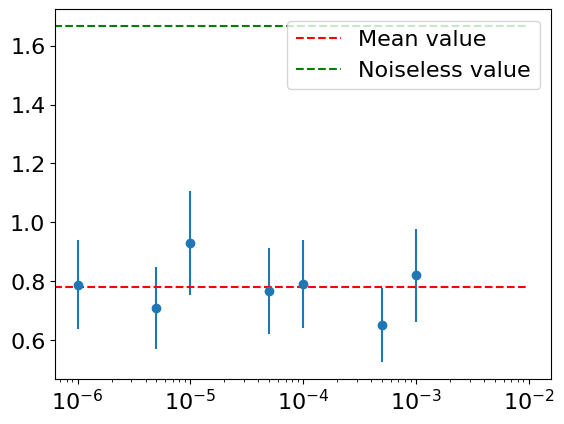

In [87]:
plt.errorbar(eps, alp_fit, yerr=alp_err_fit, fmt='o')
plt.hlines(np.mean(alp_fit), xmin=0, xmax=0.01, colors='r', linestyles='--', label='Mean value')
plt.hlines(aa , xmin=0, xmax=0.01, colors='g', linestyles='--', label='Noiseless value')
plt.xscale('log')
plt.legend()

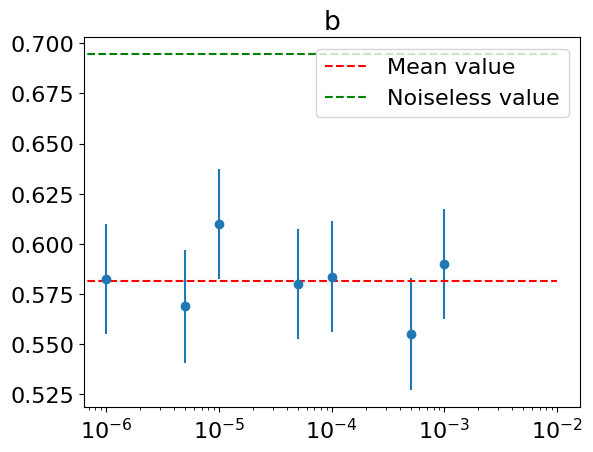

In [88]:
plt.errorbar(eps, bet_fit, yerr=bet_err_fit, fmt='o')
plt.hlines(np.mean(bet_fit), xmin=0, xmax=0.01, colors='r', linestyles='--', label='Mean value')
plt.hlines(bb , xmin=0, xmax=0.01, colors='g', linestyles='--', label='Noiseless value')
plt.xscale('log')
plt.title("b")
plt.legend()

### difference in E(t) noisy and noiseless

In [89]:
xx = np.arange(1, 25001, 1, dtype =int)

In [90]:
sel = 6

-0.0004795965890973415
0.024846098438900635
0.005172210319002329
0.009448915244282692
-0.0035788361132127167
-0.007229551783479048
0.005769179298043723
-0.0035371055133340446
0.0066454182997232
0.014697744010709292


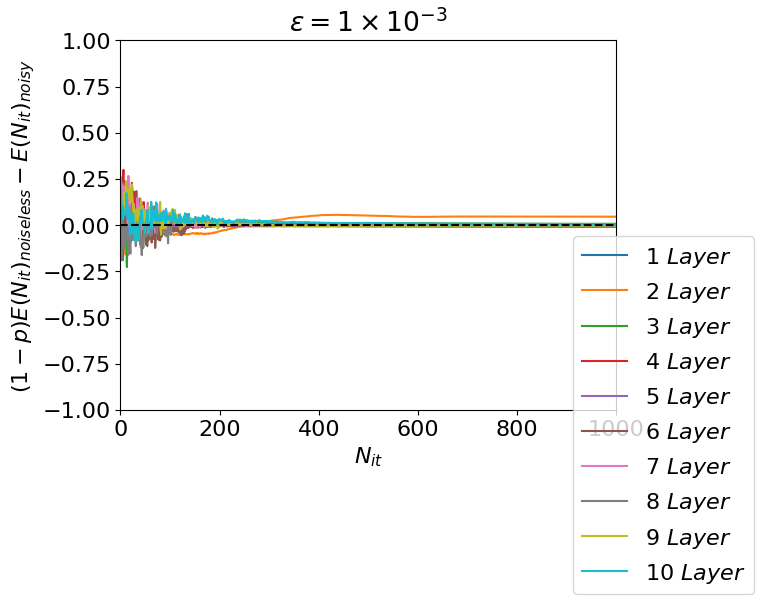

In [91]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for gt in dep:
    diff = np.multiply(exp_off[sel][gt-1], np.array(res_data_idm[gt-1]))- np.array(noisy_data_mean['%s'%sel][gt-1])
    #print(np.multiply(exp_off[sel][gt-1], res_data_idm[gt-1][-1]) - np.min(res_data_mean[gt-1]))
    #diff = np.multiply(exp_off[sel][gt-1]*np.ones(len(res_data_idm[gt-1])), np.array(res_data_idm[gt-1]))- np.array(res_data_mean[gt-1])
    print(np.mean(diff[0:1000]))
    ax.plot(xx, diff, label = r'$%s~Layer$' %(gt))
ax.set_xlabel(r'$N_{it}$')
ax.set_ylabel(r'$ (1-p)E(N_{it})_{noiseless}- E(N_{it})_{noisy}$')
ax.legend(ncol = 1, bbox_to_anchor = (1.3, 0.5))
plt.axis([0, 1000, -1, 1])
#ax.set_yscale('log')
plt.title( r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[sel][0], base_expo[sel][1]))
plt.axhline(0, color = 'k', xmin = 0, xmax = 25000, linestyle = '--')
#plt.savefig('opt_trace_diff.pdf', bbox_inches = 'tight')
plt.show()

### difference in $E_\infty$ noisy and noiseless

/tmp/ipykernel_7179/2050509980.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_xticklabels(gate_ctt)


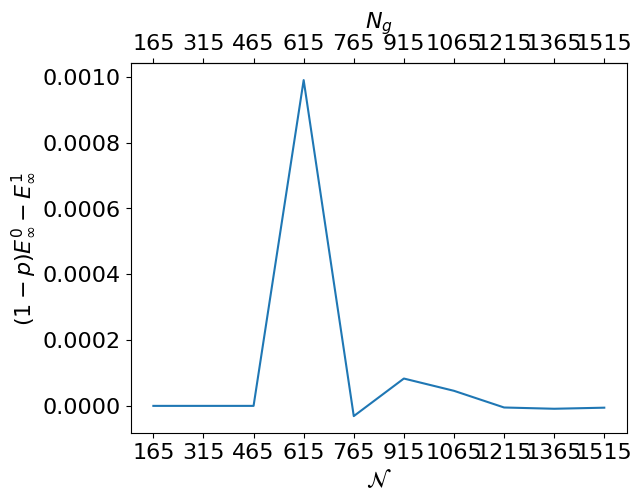

In [92]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
diff = np.multiply(np.array(exp_off[sel]), np.array(val_list_idm)) - np.array(noisy_data_val_m['%s'%sel])
ax.plot(gate_ctt, diff)
ax.set_xlabel('$\mathcal{N}$')
ax.set_ylabel(r'$ (1-p)E_{\infty}^0 - E_{\infty}^1$')
ax.set_xticks(gate_ctt)
axx = ax.secondary_xaxis('top')
axx.set_xticklabels(gate_ctt)
axx.set_xlabel(r'$N_g$')
axx.set_xticks(gate_ctt)
axx.set_xticklabels(gate_ctt)
#ax.legend(ncol = 2, bbox_to_anchor = (1.5, 0.25))
#plt.axis([0, 5000, -0.5, 0.5])
#ax.set_yscale('log')
plt.show()

### $E_\infty$ as a function of $\mathcal{N}$

In [93]:
import itertools
marker = itertools.cycle(('o-', 'v-', 's-', 'd-', '*-', '^-', 'x-', 'p-')) 

/tmp/ipykernel_7179/455224379.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(gate_ctt, val_list_idm, yerr = val_list_ids, fmt='o-', markersize=4,
/tmp/ipykernel_7179/455224379.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_xticklabels(gate_ctt)


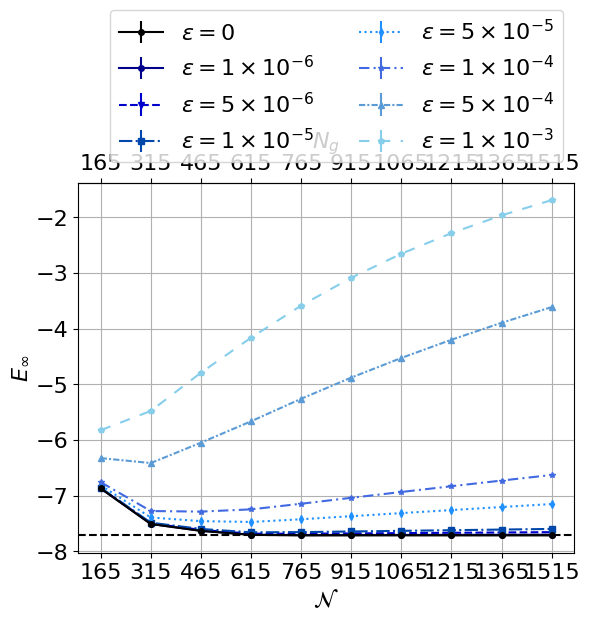

In [97]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Define shades of blue for epsilon > 0 (darker shades for better visibility)
blue_shades = ['#00008B', '#0000CD', '#0047AB', '#1E90FF', '#4169E1', '#5B9BD5', '#87CEEB']

# Define line styles for epsilon > 0
line_styles = ['-', '--', '-.', ':', (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1)), (0, (5, 5))]

# Define marker styles
markers = ['o', 'v', 's', 'd', '*', '^', 'p']

# Plot epsilon = 0 in black
plt.errorbar(gate_ctt, val_list_idm, yerr = val_list_ids, fmt='o-', markersize=4, 
             color='black', linestyle='-', label = r'$\epsilon = 0$')

# Plot epsilon > 0 in shades of blue with different line styles
for rt in range(len(base_expo)):
    plt.errorbar(gate_ctt, np.array(noisy_data_val_m['%s'%rt]), yerr = noisy_data_val_s['%s'%rt], 
                 fmt=markers[rt % len(markers)], markersize=4, barsabove = True, 
                 color=blue_shades[rt % len(blue_shades)], 
                 linestyle=line_styles[rt % len(line_styles)],
                 label = r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[rt][0], base_expo[rt][1]))
ax.set_xlabel(r'$\mathcal{N}$')
ax.set_ylabel(r'$ E_\infty$')
ax.set_xticks(gate_ctt)
axx = ax.secondary_xaxis('top')
axx.set_xticklabels(gate_ctt)
axx.set_xlabel(r'$N_g$')
axx.set_xticks(gate_ctt)
axx.set_xticklabels(gate_ctt)
plt.axhline(g_en5, color = 'k', xmin = 0, xmax = 500, linestyle = '--')
plt.legend(ncol = 2, bbox_to_anchor = (1, 1.5))
#ax.set_yscale('log')
plt.grid()
#plt.savefig('noisy_noiseless_conv_COBY.pdf', bbox_inches = 'tight')
plt.show()

/tmp/ipykernel_7179/3339149092.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(gate_ctt, val_list_idm, yerr = val_list_ids, fmt='o-', markersize=4,


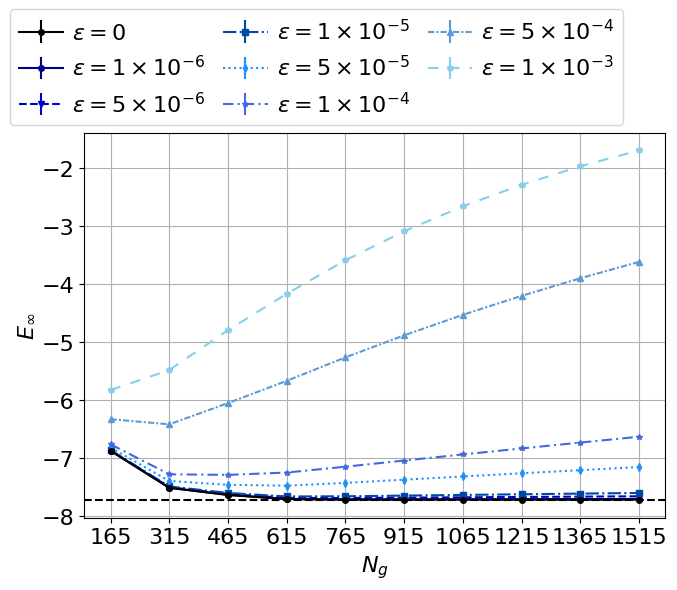

In [98]:
fig = plt.figure(figsize=(7.5, 5))
ax = fig.add_subplot(1, 1, 1)

# Define shades of blue for epsilon > 0 (darker shades for better visibility)
blue_shades = ['#00008B', '#0000CD', '#0047AB', '#1E90FF', '#4169E1', '#5B9BD5', '#87CEEB']

# Define line styles for epsilon > 0
line_styles = ['-', '--', '-.', ':', (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1)), (0, (5, 5))]

# Define marker styles
markers = ['o', 'v', 's', 'd', '*', '^', 'p']

# Plot epsilon = 0 in black
plt.errorbar(gate_ctt, val_list_idm, yerr = val_list_ids, fmt='o-', markersize=4, 
             color='black', linestyle='-', label = r'$\epsilon = 0$')

# Plot epsilon > 0 in shades of blue with different line styles
for rt in range(len(base_expo)):
    plt.errorbar(gate_ctt, np.array(noisy_data_val_m['%s'%rt]), yerr = noisy_data_val_s['%s'%rt], 
                 fmt=markers[rt % len(markers)], markersize=4, barsabove = True, 
                 color=blue_shades[rt % len(blue_shades)], 
                 linestyle=line_styles[rt % len(line_styles)],
                 label = r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[rt][0], base_expo[rt][1]))
ax.set_ylabel(r'$ E_\infty$')
ax.set_xticks(gate_ctt)
ax.set_xlabel(r'$N_g$')
ax.set_xticklabels(gate_ctt)
plt.axhline(g_en5, color = 'k', xmin = 0, xmax = 500, linestyle = '--')
# Create the legend with all lines
plt.legend(ncol = 3,
           loc = "upper center",     
           labelspacing=0.5,
            columnspacing=0.8,    # vertical space between entries (default ~0.5)
            bbox_to_anchor = (0.4, 1.35),
            handletextpad=0.4)   # space between handle and text
#plt.legend(ncol = 2, loc = "upper center", bbox_to_anchor = (0.5, 1.35))
#ax.set_xscale('log')
plt.grid()
plt.savefig('Figs/noisy_noiseless_conv_COBY.pdf', bbox_inches = 'tight')
plt.show()

In [118]:
n_lay = 10

In [119]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(b * x)

In [120]:
# Define exponential model
def lin_model(x, a, b):
    return a * x + b

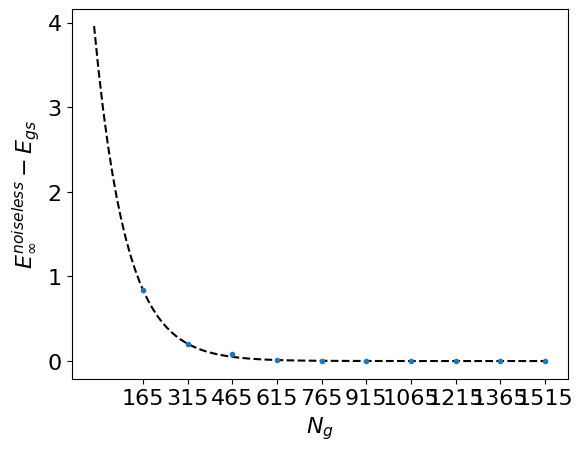

In [121]:
#fitting power law on noiseless gamma
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#plt.plot(gate_ctt[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5, 'o')
plt.errorbar(gate_ctt[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5, yerr = val_list_ids[0:n_lay], fmt='.')
#pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)

#Fit model with weights
#pm, cv = curve_fit(lin_model, gate_ctt[0:n_lay], np.log(np.array(val_list_idm[0:n_lay]) - g_en5))
pm, cv = curve_fit(lin_model, gate_ctt[0:n_lay], np.log(np.array(val_list_idm[0:n_lay]) - g_en5), sigma=np.divide(val_list_ids[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5), absolute_sigma=True)
a, b = pm
a_er, b_er = np.sqrt(np.diag(cv))

#Plot fitted exponential model
x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
y_fit = exp_model(x_fit, np.exp(b), a)

a_err = np.exp(b_er)
b_err = a_er

y_fitt = exp_model(gate_ctt[0:n_lay], np.exp(b), a)

residuals = np.array(val_list_idm[0:n_lay]) - g_en5 - y_fitt
chi_sq = np.sum(np.divide(residuals, np.array(val_list_ids[0:n_lay])))
ss_res = np.sum(residuals**2)
ss_tot = np.sum((np.array(np.array(val_list_idm[0:n_lay]) - g_en5)-np.mean(np.array(val_list_idm[0:n_lay]) - g_en5))**2)
r_sq = 1 - (ss_res / ss_tot)

# Create sequence of 100 numbers from 0 to 100 
#xn = np.linspace(1, gate_ct[n_lay-1], num=50)

# Plot regression line
ax.plot(x_fit, y_fit, '--k', lw=1.5);
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
ax.set_ylabel(r'$E_{\infty}^{noiseless} - E_{gs}$')

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim([50,900])
#ax.set_ylim([-0.1, 1])
#plt.savefig('COBYLA_plots/noiseless_conv_en_fit_COBY.pdf', bbox_inches = 'tight')
plt.show()

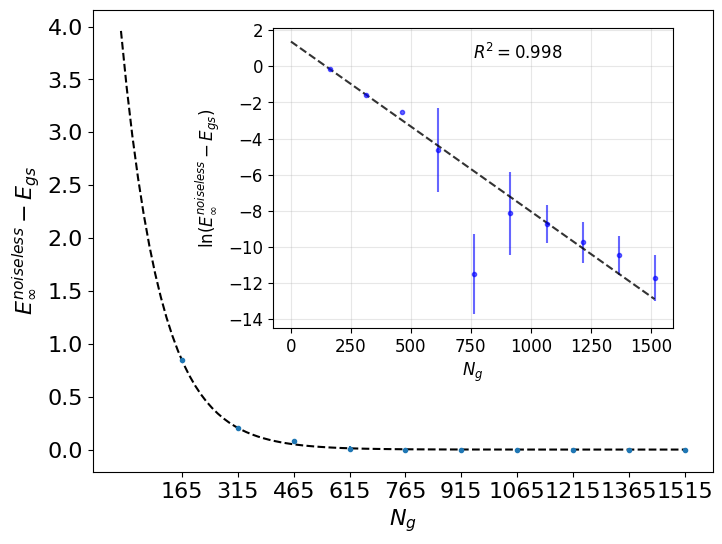

In [122]:
# Create main figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Create inset axes for log-linear plot
inset_ax = fig.add_axes([0.35, 0.35, 0.5, 0.5])  # [left, bottom, width, height]

# Main plot
ax.errorbar(gate_ctt[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5, 
             yerr=val_list_ids[0:n_lay], fmt='.')

# Fit model with weights
pm, cv = curve_fit(lin_model, gate_ctt[0:n_lay], 
                  np.log(np.array(val_list_idm[0:n_lay]) - g_en5), 
                  sigma=np.divide(val_list_ids[0:n_lay], 
                                np.array(val_list_idm[0:n_lay]) - g_en5), 
                  absolute_sigma=True)
a, b = pm
a_er, b_er = np.sqrt(np.diag(cv))

# Plot fitted exponential model in main axes
x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
y_fit = exp_model(x_fit, np.exp(b), a)
ax.plot(x_fit, y_fit, '--k', lw=1.5)

# Inset: log-linear plot
y_data = np.array(val_list_idm[0:n_lay]) - g_en5
inset_ax.errorbar(gate_ctt[0:n_lay], np.log(y_data), 
                 yerr=np.divide(val_list_ids[0:n_lay], y_data), 
                 fmt='.', color='blue', alpha=0.6)
inset_ax.plot(x_fit, np.log(y_fit), '--k', lw=1.5, alpha=0.8)

# Main axes settings
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
ax.set_ylabel(r'$E_{\infty}^{noiseless} - E_{gs}$')
#ax.set_xlim([50,900])
#ax.set_ylim([-0.1, 1])

# Inset axes settings
inset_ax.set_xlabel(r'$N_g$', fontsize=12)
inset_ax.set_ylabel(r'$\ln(E_{\infty}^{noiseless} - E_{gs})$', fontsize=12)
inset_ax.tick_params(axis='both', which='major', labelsize=12)
inset_ax.grid(True, alpha=0.3)

# Add R² value to inset
r_squared_text = f'$R^2={r_sq:.3f}$'
inset_ax.text(0.5, 0.95, r_squared_text, transform=inset_ax.transAxes, 
              fontsize=12, verticalalignment='top')

plt.savefig('Figs/noiseless_conv_en_fit_COBY_inset.pdf', bbox_inches = 'tight')

plt.show()

In [123]:
print(np.exp(b), a_err, a, b_err)

3.9963206737751635 1.0000000000051028 -0.009433079841830446 3.0188921252464634e-14


In [124]:
print(r_sq, chi_sq)

0.9984599875744752 3814165207.9153976


In [125]:
ss_res

0.0009688482517013246

In [126]:
a

-0.009433079841830446

In [127]:
b

1.3853741062590363

In [128]:
a_er

3.0188921252464634e-14

In [129]:
b_er

5.1028796554251646e-12